In [1]:
import re
import time
import html
from selenium import webdriver
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import nltk
from nltk.corpus import stopwords
import warnings
from PIL import Image
import numpy as np

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# БЫСТРЫЙ ПАРСЕР
start = time.time()
url = "https://www.imdb.com/title/tt0460649/reviews/"

# Создаем экземпляр браузера
driver = webdriver.Chrome()

# Открываем страницу
driver.get(url)

# Ждем некоторое время, чтобы страница успела загрузиться
time.sleep(2)

# Проскроллим страницу до тех пор, пока кнопка "Load More" не исчезнет
while True:
    try:
        load_more_button = driver.find_element(By.ID, "load-more-trigger")
        if load_more_button.is_displayed():
            load_more_button.click()
            # Ждем некоторое время, чтобы загрузились дополнительные отзывы
            time.sleep(2)
        else:
            break
    except:
        break

# Парсим полную страницу
soup = BeautifulSoup(driver.page_source, "html.parser")
review_containers = soup.find_all("div", class_="review-container")

reviews = {}  # Словарь для хранения уникальных отзывов

for review_container in review_containers:
    review_id = review_container.find("a", class_="title")["href"]  # Идентификатор отзыва

    # Проверка на уникальность отзыва по его идентификатору
    if review_id not in reviews:
        title = review_container.find("a", class_="title").text.strip()
        display_name = review_container.find("span", class_="display-name-link").text.strip()
        review_date = review_container.find("span", class_="review-date").text.strip()
        
        # Попробуйте извлечь текст отзыва внутри контейнера отзыва
        try:
            review_text = review_container.find("div", class_="text show-more__control").get_text(strip=True)
        except AttributeError:
            review_text = review_container.find("div", class_="text show-more__control clickable").get_text(strip=True)
        # Найти элемент с классом "rating-other-user-rating"
        rating_element = review_container.find("span", class_="rating-other-user-rating")

        if rating_element:
            # Извлечь текст из элемента
            rating_text = rating_element.get_text(strip=True)

            # Разбить текст на части, используя "/"
            parts = rating_text.split('/')

            # Проверить, что получилось две части
            if len(parts) == 2:
                rating_value = parts[0].strip()
                # Преобразовать значение оценки в число
                rating = int(rating_value)
                reviews[review_id] = {
                    "Заголовок отзыва": title,
                    "Имя пользователя": display_name,
                    "Дата отзыва": review_date,
                    "Оценка": rating,
                    "Текст отзыва": review_text
                }
            else:
                rating = None
        else:
            rating = None

# Закрываем браузер
driver.quit()

# Преобразование словаря в список
unique_reviews = list(reviews.values())
print(f"Количество отзывов: {len(unique_reviews)}")
print(f"Время выполнения: {time.time() - start} секунд")

Количество отзывов: 955
Время выполнения: 121.07355737686157 секунд


Было обработано 1011 отзывов, из которых 56 не имели оценку. Таким образом, была проведена очистка и они не были включены в конечный датасет отзывов. Каждый отзыв имеет 5 полей: Имя пользователя, Дата отзыва, Заголовок отзыва, Оценка (от 1 до 10) и Текст отзыва.

In [4]:
df = pd.DataFrame(unique_reviews)
date_format = '%d %B %Y'
df['Дата отзыва'] = pd.to_datetime(df['Дата отзыва'], format=date_format)
print("Описательная статистика рейтингов:")
print(df["Оценка"].describe())

print(f"Средняя оценка: {df['Оценка'].mean()}")
print(f"Медианная оценка: {df['Оценка'].median()}")

print(f"Минимальная оценка: {df['Оценка'].min()}")
print(f"Максимальная оценка: {df['Оценка'].max()}")


Описательная статистика рейтингов:
count    955.000000
mean       7.801047
std        2.868940
min        1.000000
25%        7.000000
50%        9.000000
75%       10.000000
max       10.000000
Name: Оценка, dtype: float64
Средняя оценка: 7.801047120418848
Медианная оценка: 9.0
Минимальная оценка: 1
Максимальная оценка: 10


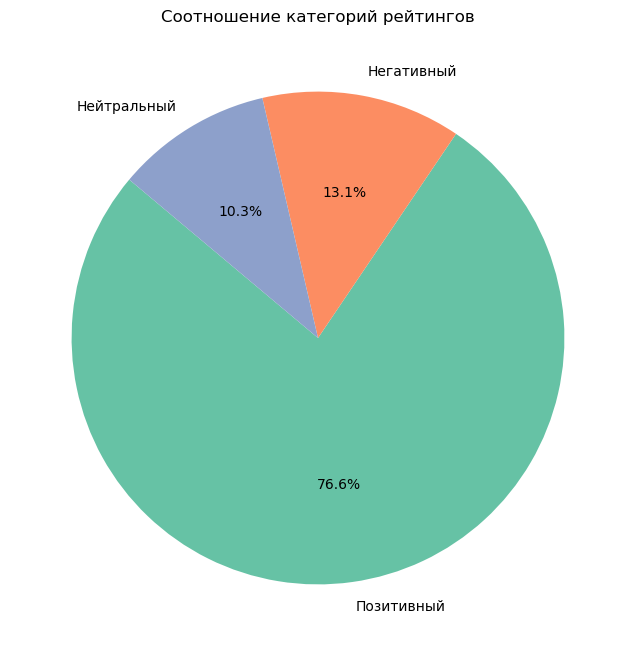

In [5]:
def classify_rating(rating):
    if rating >= 7:
        return "Позитивный"
    elif rating >= 4:
        return "Нейтральный"
    else:
        return "Негативный"

df['Категория рейтинга'] = df['Оценка'].apply(classify_rating)

rating_counts = df['Категория рейтинга'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Соотношение категорий рейтингов')
plt.show()


Большинство отзывов 76.6% положительные, 10.3% нейтральные, 13.1% отрицательные, значит, что модель оценивания будет неточной

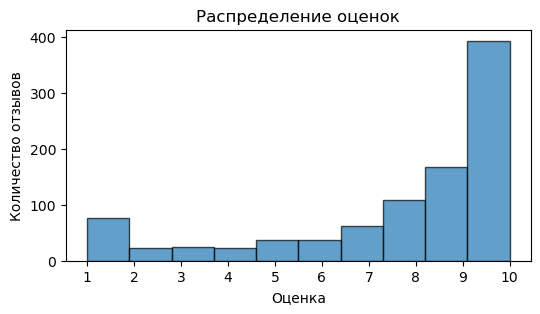

In [6]:
plt.figure(figsize=(6, 3))
plt.hist(df["Оценка"], bins=10, align='mid', edgecolor='k', alpha=0.7)
plt.xlabel("Оценка")
plt.ylabel("Количество отзывов")
plt.title("Распределение оценок")
plt.xticks(list(range(1, 11)))
plt.show()

Из графика видно, что самой популярной оценкой является оценка 10 (около 400 отзывов), также около 200 пользователей оценили фильм на 9. Далее идет плавный спуск - чем меньше оценка, тем меньше количество таких отзывов. Таким образом, видна довольно сильная несбалансированность в данных. Далее будет применены `random oversampling` и `random undersampling` для перебалансировки классов с целью улучшить данные для обучения модели

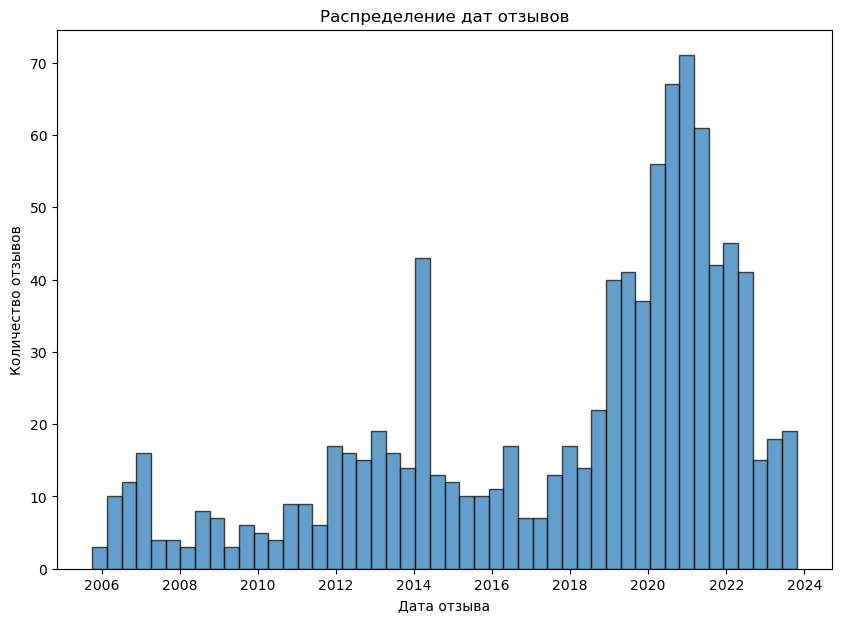

In [7]:
plt.figure(figsize=(10, 7))
plt.hist(df["Дата отзыва"], bins=48, edgecolor='k', alpha=0.7)
plt.xlabel("Дата отзыва")
plt.ylabel("Количество отзывов")
plt.title("Распределение дат отзывов")
plt.show()

Из распределения видно, что большинство отзывов (более 2000) были оставлены в январе? феврале и марте
2020 года, в первые месяцы после выхода фильма в мировой прокат. Также многократное повышение количества отзывов относительно соседних месяцев наблюдается в сентябре 2022 года.

## Формирование облака слов

При формировании облака слов убраны стоп слова, а также слова "movie" и "film" так как они являются крайне популярными в отзывах, занимают очень много места при визуализации и не имеют смысловой нагрузки.

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79871\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

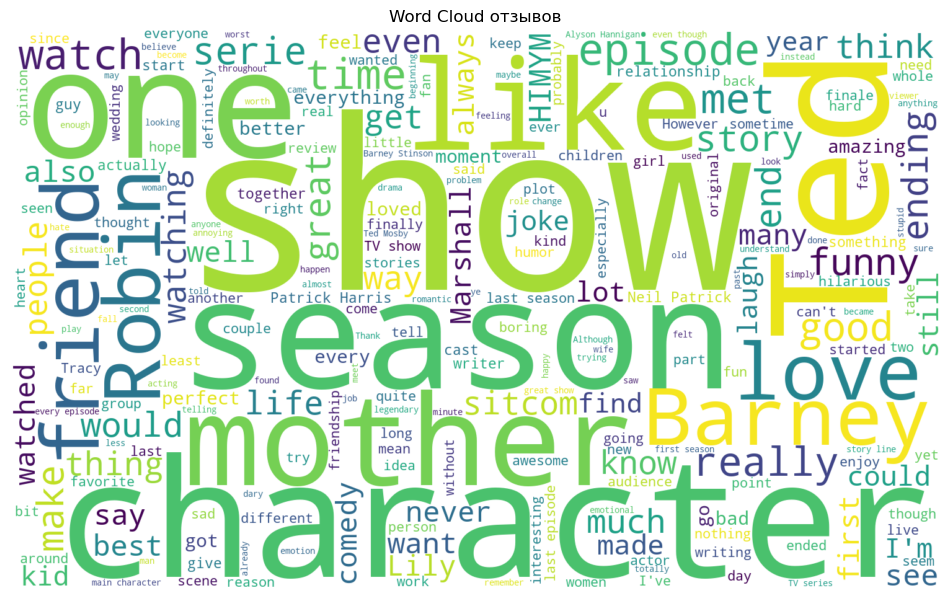

In [9]:
stop_words = set(stopwords.words('english'))
stop_words.add('movie')
stop_words.add('film')
all_reviews_text = ' '.join(df['Текст отзыва'])

wordcloud = WordCloud(width=1500, height=900, background_color='white', stopwords=stop_words, collocations=True, max_words=250).generate(all_reviews_text)


plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud отзывов')
plt.show()

Так как это сериал, то очкивдно, что самым популярным словом будет show. Кроме того, популярными словами являются mother, character и season, это свидетельствует нам о том, что у пользователей есть любимые персонажи и сезоны. Также пользователи часто отмечают Барни, одного из главных героев, он является одним из самых харизматичных персонажей сериала. Также довольно крупным является словосочетание "one", "friend" и "Ted", что говорит о том, что пользователи часто друзей, главного героя Теда и то, что это один из лучших сериало современности.

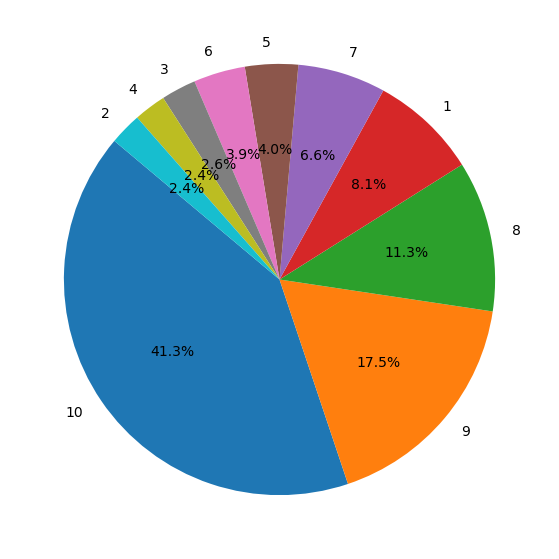

In [10]:
plt.figure(figsize=(10,7))
plt.pie(df['Оценка'].value_counts(), autopct='%1.1f%%', startangle=140, labels=df['Оценка'].value_counts().index)
plt.show()

Из диаграммы видно, что наблюдается явная разбалансировка классов, поэтому применим Undersampling и Oversampling.

In [11]:
!pip install imblearn

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Обучение с применением Undersampling и Oversampling.

In [13]:
df['Text'] = df['Заголовок отзыва'] + ' ' + df['Текст отзыва']

# Преобразование текста в числовой формат (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X = tfidf_vectorizer.fit_transform(df['Text'])
y = df['Оценка']

# Используем RandomOverSampler для увеличения представленности классов
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Используем RandomUnderSampler для уменьшения представленности классов
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42)

In [14]:
# Модель с использованием SVM
start_time = time.time()
svm_model = SVC()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time
start_time = time.time()
y_pred_svm = svm_model.predict(X_test)
test_time = time.time() - start_time
accuracy_svm = svm_model.score(X_test, y_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        79
           2       1.00      1.00      1.00        56
           3       1.00      1.00      1.00        66
           4       1.00      1.00      1.00        57
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        69
           7       1.00      1.00      1.00        58
           8       0.92      0.98      0.95        49
           9       0.90      0.94      0.92        48
          10       0.85      0.85      0.85        59

    accuracy                           0.97       591
   macro avg       0.97      0.97      0.97       591
weighted avg       0.97      0.97      0.97       591



In [15]:
# Модель с использованием Случайного леса (Random Forest)
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
training_time_rf = time.time() - start_time
start_time = time.time()
y_pred_rf = rf_model.predict(X_test)
test_time_rf = time.time() - start_time
accuracy_rf = rf_model.score(X_test, y_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        79
           2       1.00      1.00      1.00        56
           3       1.00      1.00      1.00        66
           4       1.00      1.00      1.00        57
           5       1.00      1.00      1.00        50
           6       1.00      1.00      1.00        69
           7       1.00      1.00      1.00        58
           8       1.00      1.00      1.00        49
           9       0.98      0.96      0.97        48
          10       0.89      0.98      0.94        59

    accuracy                           0.99       591
   macro avg       0.99      0.99      0.99       591
weighted avg       0.99      0.99      0.99       591



In [16]:
# Модель с использованием Наивного Байесовского классификатора (Multinomial Naive Bayes)
start_time = time.time()
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
training_time_nb = time.time() - start_time
start_time = time.time()
y_pred_nb = nb_model.predict(X_test)
test_time_nb = time.time() - start_time
accuracy_nb = nb_model.score(X_test, y_test)
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.78      0.88        79
           2       0.98      1.00      0.99        56
           3       0.93      1.00      0.96        66
           4       0.97      1.00      0.98        57
           5       0.96      1.00      0.98        50
           6       1.00      1.00      1.00        69
           7       0.95      1.00      0.97        58
           8       0.63      0.98      0.77        49
           9       0.68      0.85      0.76        48
          10       0.92      0.37      0.53        59

    accuracy                           0.90       591
   macro avg       0.90      0.90      0.88       591
weighted avg       0.91      0.90      0.89       591



In [17]:
# Модель с использованием Градиентного бустинга (Gradient Boosting)
start_time = time.time()
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
training_time_gb = time.time() - start_time
start_time = time.time()
y_pred_gb = gb_model.predict(X_test)
test_time_gb = time.time() - start_time
accuracy_gb = gb_model.score(X_test, y_test)
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.96      0.97        79
           2       0.98      1.00      0.99        56
           3       1.00      1.00      1.00        66
           4       1.00      1.00      1.00        57
           5       0.96      1.00      0.98        50
           6       0.96      1.00      0.98        69
           7       0.94      1.00      0.97        58
           8       0.94      0.96      0.95        49
           9       0.79      0.94      0.86        48
          10       0.88      0.59      0.71        59

    accuracy                           0.95       591
   macro avg       0.94      0.95      0.94       591
weighted avg       0.95      0.95      0.94       591



## Общие выводы по всем моделям:
У всех четырех моделей примерно сопоставимые по качеству предсказания. Видно, что наиболее удачные оценки для предсказания во всех моделях это оценки 2, 3, 4, 5. Это можно объяснить тем, что в изначальной выборке отзывов с данными оценками было мало и нужно было использовать Underesampling и Oversampling. Это приводит к тому, что как в трейновой так и в тестовой выборке есть некоторое количество одинаковых отзывов, что и способствует улучшению оценки (что на самом деле не является полноценным показателем эффективности, ведь модель по сути училась на каком то количестве повторяющихся отзывов). В целом по метрикам результат довольно высокий, лучший у метода опорных векторов и случайного леса.

In [18]:
results = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'Naive Bayes', 'Gradient Boosting'],
    'Run time': [training_time+test_time, training_time_rf+test_time_rf, training_time_nb+test_time_nb, training_time_gb+test_time_gb], 
    'Training time': [training_time, training_time_rf, training_time_nb, training_time_gb],
    'Test time': [test_time, test_time_rf, test_time_nb, test_time_gb],
    'Accuracy': [accuracy_svm, accuracy_rf, accuracy_nb, accuracy_gb]
})
print("Матрица результатов:")
print()
print(results.to_string(index=False))

Матрица результатов:

            Model   Run time  Training time  Test time  Accuracy
              SVM  10.262342       8.844668   1.417674  0.969543
    Random Forest   4.868662       4.807564   0.061099  0.986464
      Naive Bayes   0.018175       0.016046   0.002130  0.895093
Gradient Boosting 142.378864     142.362466   0.016398  0.945854


## Выводы по каждой модели:
Самая высокая точность у модели Random Forest, а сразу за ней с минимальной разницей идет метод опорных векторов с результатами 0.92 и 0.916 соответсвтенно. Далее идет градиентный бустинг и наивный Байесовский классификатор с результатами 0.82 и 0.81 соответсвтенно. Самое быстрое время выполнения у навиного байесовского классификатора - более чем в 1000 раз быстрее чем у ближайшего по быстроте метода, соотвественно, при необходимости достижения масимальной скорости данный метод - лучший вариант. Самый долгий метод - градиентный бустинг - в 10000 раз медленнее, чем самый быстрый метод. В общем, наилучшие результаты по совокупности показателей (скорость выполнения и результат) у метода Random Forest - наивысшая точность и довольно маленькое время выполнения.

### Доп. задание:
Ввести заголовок и текст отзыва, а модель Random Forest предсказывает значение.

In [19]:
!pip install translate

In [20]:
from translate import Translator
translator = Translator(to_lang="en")  # "en" означает английский язык

In [21]:
# Ввод текста от пользователя
title = input("Введите заголовок отзыва: ")
text = input("Введите текст отзыва: ")

translated_title = translator.translate(title)
translated_text = translator.translate(text)

text = translated_text + ' ' + translated_title  # Объединяем заголовок и текст отзыва
text_vectorized = tfidf_vectorizer.transform([text])  # Векторизуем текст
predicted_rating = rf_model.predict(text_vectorized)[0]  # Предсказываем оценку

print(f"Предсказанная оценка: {predicted_rating}")

Введите заголовок отзыва: Прекрасный сериал!
Введите текст отзыва: Мне очень понравился сериал! Особенно герои Барни, Тед, Лили и Маршалл! Обожаю это сериал, он самый лучший!
Предсказанная оценка: 10


Видим, что модель верно определила тональность отзыва, но для данного отзыва оценка 10 выглядит преувеличением. Спарведливой была бы оценка 8-9